## Data analysis code for gain=5000 data taken on 06/03/2025. Plots histogram and fits with a Gaussian.

In [41]:
import numpy as np  
import matplotlib.pyplot as plt
import re
import os
from scipy import optimize
from scipy.ndimage import gaussian_filter
import h5py

## Define functions for Gaussian fitting

In [2]:
def gaussian(p,x):
    return p[0]/(p[1]*(2*np.pi)**.5)*np.exp(-.5*(x-p[2])**2/(p[1]**2))

#p[0]=multiplicative const
#p[1]=std
#p[2]=mean

def residual(p,x,y,dy):
    return (gaussian(p,x)-y)/dy

In [3]:
def gaussian_fit(counts,probability,probability_uncertainty,p0,plotting_values,show_details):
    ## Implement Gaussian fit
    index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max = plotting_values
    counts_for_gaussian=counts[index_Start:index_End]
    probability_for_gaussian=probability[index_Start:index_End]
    probability_uncertainty_for_gaussian=probability_uncertainty[index_Start:index_End]
    pf, cov, info, mesg, success = optimize.leastsq(residual, p0, args = (counts_for_gaussian, probability_for_gaussian, 
                                                                          probability_uncertainty_for_gaussian), full_output=1, maxfev=5000)
    ## Plot data and fit
    if cov is None:
        print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
        print('Fit did not converge')
        print('Success code:', success)
        print(mesg)
        fig = plt.figure(figsize=(8,5))
        ax = fig.add_subplot(111)
        ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5) 
            #In DarkFrameHistogramFit_polished.ipynb this plots only in the fitted range counts_for_gaussian, but this shouldn't matter if we plot it over all data points.
        x = np.linspace(Plotfit_min,Plotfit_max,1000)
        ax.plot(x, gaussian(p0, x), 'b-', label = 'Guess')
        ax.legend()
        ax.set_title('Gaussian Fit')
        ax.set_xlabel('AD count')
        ax.set_ylabel('Probability')
        ax.set_yscale('log')
        ax.set_xlim([Dataplot_min,Dataplot_max])
        ax.grid()
        plt.show()
    else:
        pferr = [np.sqrt(cov[i,i]) for i in range(len(pf))]
        if show_details:
            print('fit region: AD count = ', min(counts_for_gaussian), 'to ', max(counts_for_gaussian))
            print('Fit Converged')
            chisq = sum(info['fvec']*info['fvec'])
            dof = abs(len(counts_for_gaussian)-len(pf))
            print('Converged with chi-squared', chisq)
            print('Number of degrees of freedom, dof =',dof)
            print('Reduced chi-squared', chisq/dof)
            print('Inital guess values:')
            print('  p0 =', p0)
            print('Best fit values:')
            print('  pf =', list(pf))
            print('Uncertainties in the best fit values:')
            print('  pferr =', pferr)
            print("5 sigma threshold is", pf[2]+pf[1]*5, "with uncertainty", pferr[2]+pferr[1]*5)
            fig = plt.figure(figsize=(8,5))
            ax = fig.add_subplot(111)
            ax.errorbar(counts, probability, probability_uncertainty, fmt='k.', label = 'Data',alpha=0.5)
            x = np.linspace(Plotfit_min,Plotfit_max,1000) #plot fitted curve
            ax.set_yscale('log')
            ax.plot(x, gaussian(pf, x), 'r-', label = 'Fit curve')
            ax.axvspan(min(counts_for_gaussian), max(counts_for_gaussian), alpha=0.4, color='red', label = 'Fitted region')
            ax.set_title('Gaussian Fit', fontsize=16)
            ax.set_xlabel('AD count', fontsize=16)
            ax.set_ylabel('Probability', fontsize=16)
            ax.grid()
            ax.legend(loc=3)
            ax.set_xlim([Dataplot_min,Dataplot_max])
            # ax.set_ylim([1e-6,1e-1])
            plt.tight_layout()
            plt.show()
    return pf

# Define PC thresholds for binning=1x1
Code copied from 03/14/2025
At every sequence we stopped in the middle

In [4]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\06\03'

Text(0, 0.5, 'Number of Pixels')

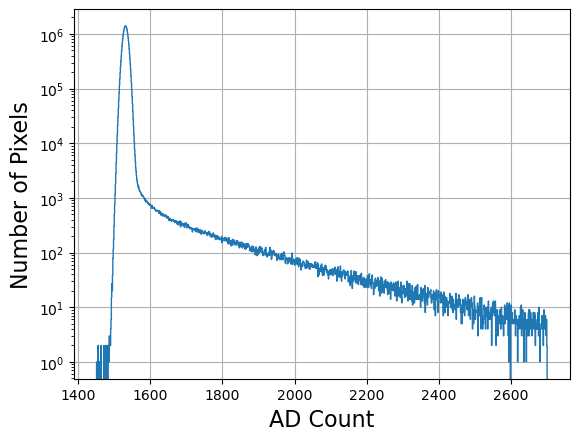

In [5]:
# get threshold values from averaged 0mW data
all_images = np.full((300, 512, 512), np.NaN)
folder_path = folder_path_day + '\\0004'
for count_b, filename in enumerate(os.listdir(folder_path)):
    if count_b<100: #FIRST 10 SHOTS
        file_path = os.path.join(folder_path, filename)
        with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            all_images[count_b, :, :] = image_data

background_counts = all_images.ravel()

#Plot histogram for total 100 pics
plt.figure(3)
background_bins=plt.hist(background_counts,bins=np.arange(1450.5,2700.5, 1),log=True, histtype='step')
counts=background_bins[1][:-1]+.5
counts=counts.astype(int)

plt.grid()
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of Pixels', fontsize=16)

# # Plot error rate 
# plt.figure(4)
# plt.hist(background_counts,bins=np.arange(1450.5,2700.5),log=True, histtype='step', density = True, cumulative=-1)
# plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Error rate', fontsize=16)
# plt.show()

[3.12673504e-01 7.00000000e+00 1.53200000e+03]
[59, 99, 1503, 1555, 1480, 1900]
fit region: AD count =  1510 to  1549
Fit Converged
Converged with chi-squared 1221.5265601521605
Number of degrees of freedom, dof = 37
Reduced chi-squared 33.0142313554638
Inital guess values:
  p0 = [0.3126735035357239, 7, 1532]
Best fit values:
  pf = [0.3306409325257683, 7.426193835311889, 1531.6877616210222]
Uncertainties in the best fit values:
  pferr = [6.527457188952597e-05, 0.0012100760273948572, 0.0015224617734143195]
5 sigma threshold is 1568.8187307975816 with uncertainty 0.007572841910388606


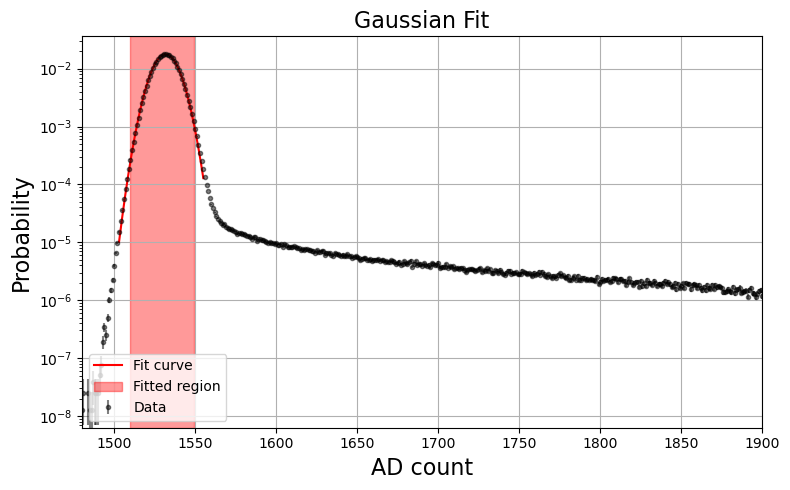

In [6]:
# Get threshold
probability=background_bins[0]/len(background_counts) #Assuming each pixel get 0 or 1 photon -SF
probability_uncertainty=(.1+background_bins[0])**.5/len(background_counts) #Shot noise? -SF
peak_probability = np.max(probability)
peak_index = np.argmax(probability)
peak=counts[peak_index]

#Select x region where you want to fit the gaussian: this can be arbirary
Start_gaussian=1510
End_gaussian=1550

index_Start = np.abs(counts - Start_gaussian).argmin() #closest_index_to_Start_gaussian
index_End = np.abs(counts - End_gaussian).argmin() #closest_index_to_End_gaussian

# Select x region where you want to plot the fitted gaussian: this must include the above region
Plotfit_min = counts[index_Start] -7
Plotfit_max = counts[index_End] +5

# Select x region where you want to plot the data: this must include the above region
Dataplot_min = 1480
Dataplot_max = 1900

# Guess the std of your Gaussian fit!
guess_std=7

print(np.array([peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak]))
# Now apply the Gaussian fit to your histogram and plot...
plotting_values = [index_Start, index_End, Plotfit_min, Plotfit_max, Dataplot_min, Dataplot_max]
print(plotting_values)
pf=gaussian_fit(counts,probability,probability_uncertainty, [peak_probability * (guess_std*np.sqrt(2*np.pi)), guess_std, peak], plotting_values,show_details=True) #Note that peak value of normal distribution with std=X is 1/(X*sqrt(2pi))
 

# Binning 1x1

In [26]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\06\03'

2025-06-03_0007_BaF_Fluorescence_002.h5


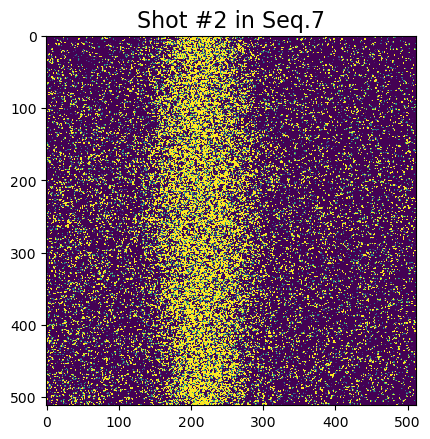

In [27]:
##Plot the shot
seq = 7 #sequence
shot_number =2 #Choose shot number you want to see

folder_path = folder_path_day + '\\%.4i'%seq
for count_b, filename in enumerate(os.listdir(folder_path)):
      if count_b==shot_number: 
          file_path = os.path.join(folder_path, filename)
          print(filename)
          with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            plt.imshow(image_data, vmin = 1550, vmax = 1600)
            plt.title('Shot #%i in Seq.%i' % (shot_number, seq), fontsize=16)
            plt.show()

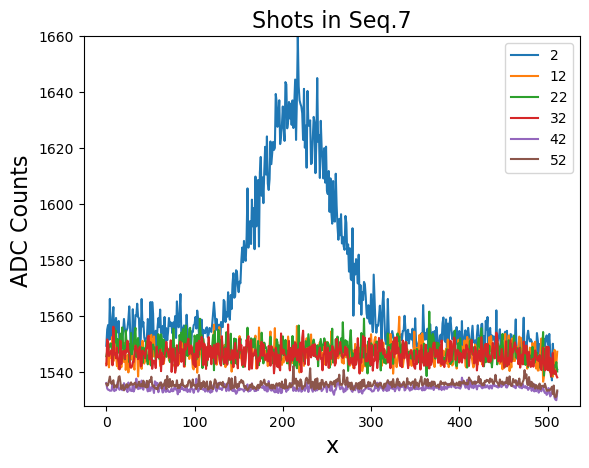

In [16]:
count_b_start=1
count_b_end=53
sum_array=[]
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
        if count_b%10==2:
        # print(count_b)
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                cross_section_x = np.mean(image_data, axis=0)
                # if np.any(cross_section_x>1550):
                plt.plot(np.arange(512),cross_section_x, label=count_b)
                # print(count_b)
                # print(np.sum(cross_section_x))
                sum_array.append(np.sum(cross_section_x))
                # else:
                    # plt.plot(np.arange(512),cross_section_x, label='')


plt.ylim([1528,1660])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('ADC Counts', fontsize=16)
plt.legend()



Text(0, 0.5, 'Total signal')

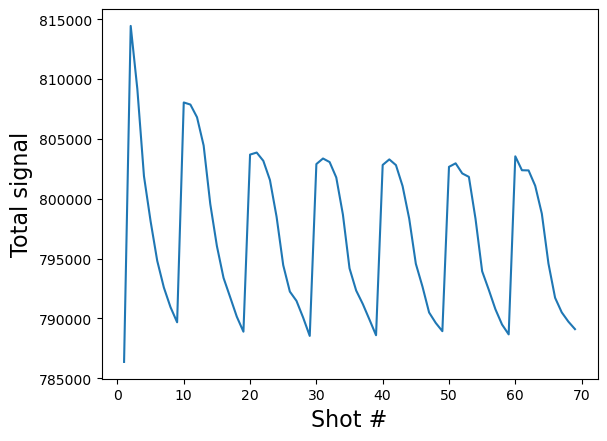

In [181]:
plt.plot(np.arange(count_b_start, count_b_end+1), sum_array)
plt.xlabel('Shot #', fontsize=16)
plt.ylabel('Total signal', fontsize=16)

In [182]:
print(2.1 + np.arange(0,5,0.5))



[2.1 2.6 3.1 3.6 4.1 4.6 5.1 5.6 6.1 6.6]


[10 20 30 40 50 60]
[ 1 11 21 31 41 51 61]
[ 2 12 22 32 42 52 62]
[ 3 13 23 33 43 53 63]
[ 4 14 24 34 44 54 64]
[ 5 15 25 35 45 55 65]
[ 6 16 26 36 46 56 66]
[ 7 17 27 37 47 57 67]
[ 8 18 28 38 48 58 68]
[ 9 19 29 39 49 59 69]


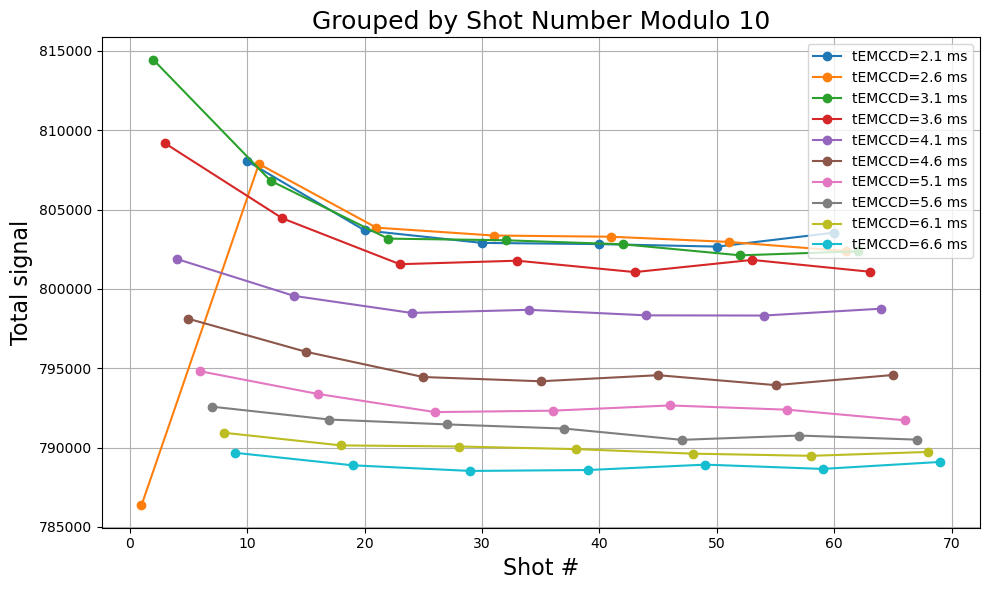

In [200]:
# Simulate example data
count_b_start = 1
count_b_end = 70
legend_numbers=2.1 + np.arange(0,5,0.5)
x_vals = np.arange(count_b_start, count_b_end)

plt.figure(figsize=(10, 6))

sum_array = np.array(sum_array, dtype=float)

# Plot each modulo-7 group
count=0
for r in range(10):
    # Select indices where x % 7 == r
    mask = (x_vals % 10) == r
    legend_number=legend_numbers[count]
    plt.plot(x_vals[mask], sum_array[mask], marker='o', label=f'tEMCCD=%.1f ms'%legend_number)
    print(x_vals[mask])
    count+=1

# Axis labels and legend
plt.xlabel('Shot #', fontsize=16)
plt.ylabel('Total signal', fontsize=16)
plt.title('Grouped by Shot Number Modulo 10', fontsize=18)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Let's subtract the background (below threshold)
Let's use typical value (threshold=1568 for 10mW)

In [42]:
folder_path_day = r'C:\Experiments\lyman29\BaF_Fluorescence\2025\06\03'
seq_binning1 = [7] #binning=1x1
labels = ['Dropcast, ',]

1535


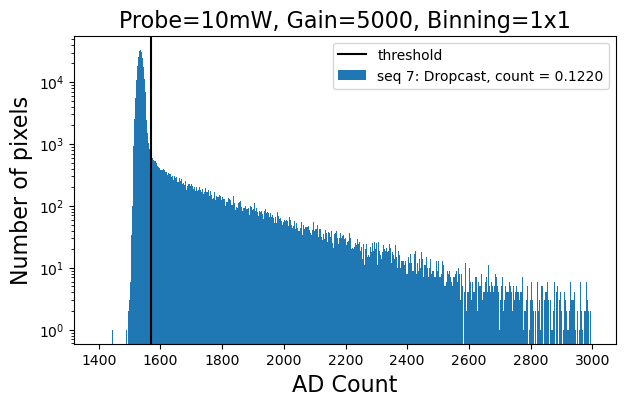

In [7]:
counting_threshold = 1568 

all_images_binning1 = np.full((len(seq_binning1), 1, 512, 512), np.NaN)
for count_a, seq in enumerate(seq_binning1):
    folder_path = folder_path_day + '\\%.4i'%seq
    for count_b, filename in enumerate(os.listdir(folder_path)):
        if count_b==2:
            file_path = os.path.join(folder_path, filename)
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                if seq==8:
                    image_data=image_data-np.ones(np.shape(image_data))*6 #added
                all_images_binning1[count_a, :, :, :] = image_data
    
counts = np.mean(all_images_binning1>counting_threshold, axis = (1,2,3))


plt.figure(figsize=(7, 4), num = 'histograms')

bins = np.arange(1400, 3000, 3)
for i, images in enumerate(all_images_binning1):
    hist, bin_edges = np.histogram(images, bins=bins)  # Adjust the number of bins as needed
    print(bin_edges[np.argmax(hist)])
    plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges),
            alpha = 1.0, label = 'seq %i: '%seq_binning1[i]+ labels[i] +'count = ' + '%.4f'%counts[i])



plt.axvline(x = counting_threshold, label = 'threshold', c = 'k')

plt.title('Probe=10mW, Gain=5000, Binning=1x1', fontsize=16)
plt.xlabel('AD Count', fontsize=16)
plt.ylabel('Number of pixels', fontsize=16)
plt.yscale('log', base=10)
plt.legend()
plt.show()

2025-06-03_0007_BaF_Fluorescence_002.h5


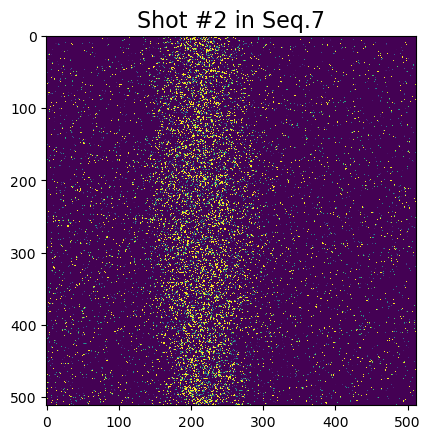

In [25]:
##Plot the shot with background subtraction
seq = 7 #sequence
shot_number =2 #Choose shot number you want to see

folder_path = folder_path_day + '\\%.4i'%seq
for count_b, filename in enumerate(os.listdir(folder_path)):
      if count_b==shot_number: 
          file_path = os.path.join(folder_path, filename)
          print(filename)
          with h5py.File(file_path, 'r') as file:
            image_data = file['images/camera/fluorescence/frame'][:]
            image_data[image_data<1568]=1400
            plt.imshow(image_data, vmin = 1568, vmax = 1700)
            plt.title('Shot #%i in Seq.%i' % (shot_number, seq), fontsize=16)

12429
[ 55  63  56  71  77  69  71  77  68  69  75  75  71  81  85  84  81  81
  85 101 111 101  90  99  94 108 103 103 104 131 105 110 122 111 130 139
 126 146 129 136 149 122 136 125 145 158 153 134 131 157 158 146 152 176
 154 151 160 158 157 157 172 170 156 178 162 157 164 160 169 163 148 168
 165 161 167 171 165 179 166 174 156 171 158 162 162 161 160 149 171 138
 168 158 138 159 141 163 145 147 144 164 154 158 138 149 141 129 119 152
 150 157 118 135 130 120 140 120 116 137 105  97 123 122 106  96 102  92
  96 101  94  91  91 108  97  89  91  81  88  74  74  76  68  63  68  71
  75  71  66  61  70  57]


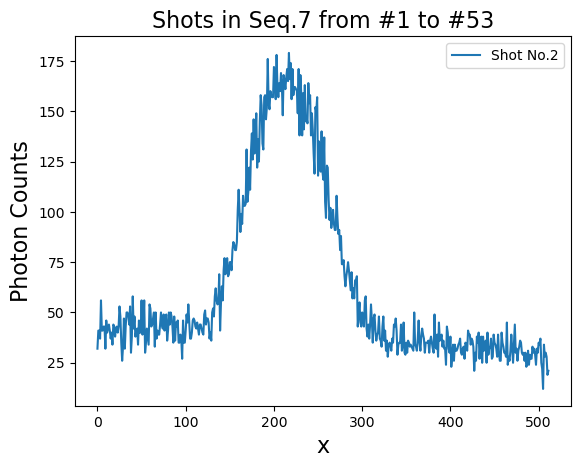

In [52]:
count_b_start=1
count_b_end=53
sum_array=[]
# get x-cross section for every shot in the sequence
for count_b, filename in enumerate(os.listdir(folder_path)): 
    file_path = os.path.join(folder_path, filename)
    # print(filename)
    # if count_b<=count_b_end and count_b>=count_b_start: #POINT WE STOPPED TAKING DATA...
    if count_b==2:
        if count_b%10==2:
        # print(count_b)
            with h5py.File(file_path, 'r') as file:
                image_data = file['images/camera/fluorescence/frame'][:]
                image_data[image_data<1568]=0  #CHANGED
                cross_section_x = np.count_nonzero(image_data, axis=0) #CHANGED
                # if np.any(cross_section_x>1550):
                plt.plot(np.arange(512),cross_section_x, label='Shot No.'+ str(count_b))
                # print(count_b)
                # print(np.sum(cross_section_x))
                print(np.sum(cross_section_x[140:290])-150*40)
                print(cross_section_x[140:290])
                # else:
                    # plt.plot(np.arange(512),cross_section_x, label='')


# plt.ylim([1528,3000])
plt.xlabel('x', fontsize=16)
# plt.title('Shots in Seq.7', fontsize=16)
plt.title('Shots in Seq.%i from #%i to #%i' %(seq, count_b_start, count_b_end), fontsize=16)
plt.ylabel('Photon Counts', fontsize=16)
plt.legend()

In [ ]:
# get total number of photons from molecular fluorescence
